In [1]:
dataset_root="./speed/speed/"
import pandas as pd
import os
import json
import numpy as np
import keras
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.layers import Dense,Flatten,Activation
from sklearn.model_selection import train_test_split
from numpy import linalg as LA
from keras.preprocessing import image

In [4]:
dataset_root="./speed/speed/"
with open(os.path.join(dataset_root,'train.json'),'r') as train:
  train_json=json.load(train)
train_json[0]['q_vbs2tango']

[-0.419541, -0.484436, -0.214179, 0.73718]

In [5]:
imgname_list=[]
for i in range(len(train_json)):
  imgname_list.append(train_json[i]['filename'])


In [7]:
label_list=[]
q1,q2,q3,q4,r1,r2,r3=[],[],[],[],[],[],[]
for i in range(len(train_json)):
  q1.append(train_json[i]['q_vbs2tango'][0])
  q2.append(train_json[i]['q_vbs2tango'][1])
  q3.append(train_json[i]['q_vbs2tango'][2])
  q4.append(train_json[i]['q_vbs2tango'][3])
  r1.append(train_json[i]['r_Vo2To_vbs_true'][0])
  r2.append(train_json[i]['r_Vo2To_vbs_true'][1])
  r3.append(train_json[i]['r_Vo2To_vbs_true'][2])

In [9]:
col_dict={'image_names':imgname_list,'q1':q1,'q2':q2,'q3':q3,'q4':q4,'r1':r1,'r2':r2,'r3':r3}
df=pd.DataFrame(col_dict)

In [10]:
df

,image_names,q1,q2,q3,q4,r1,r2,r3
0,img000001.jpg,-0.419541,-0.484436,-0.214179,0.737180,-0.210810,-0.094466,6.705986
1,img000002.jpg,0.516575,-0.514759,0.684166,0.009504,0.116806,-0.007084,3.046739
2,img000003.jpg,0.500257,-0.696092,0.398871,0.325731,0.565498,-0.182691,12.963307
3,img000004.jpg,0.801200,-0.209980,0.217208,0.516534,0.326352,0.069790,10.924485
4,img000005.jpg,0.541851,-0.724470,-0.294286,-0.308118,0.003599,0.057942,3.419766
...,...,...,...,...,...,...,...,...
11995,img014993.jpg,-0.011224,0.853617,0.520732,0.007101,0.065715,0.014525,4.593587
11996,img014995.jpg,-0.136158,0.202604,-0.263805,-0.933177,-0.297850,0.095025,5.438033
11997,img014996.jpg,-0.037408,-0.455217,0.584207,0.670880,-0.066601,-0.116946,7.941392
11998,img014997.jpg,-0.299891,0.662877,-0.593075,-0.344850,0.132443,0.099254,6.178893


In [11]:
df_train,df_test=train_test_split(df,test_size=0.2)
len(df_test)

2400

In [12]:
path="./speed/speed/images/train"
cols=['q1','q2','q3','q4','r1','r2','r3']
datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=datagen.flow_from_dataframe(df_train,directory=path,x_col='image_names',y_col=cols,class_mode='other',target_size=(224,224),batch_size=32,color_mode='rgb')
validation_generator=datagen.flow_from_dataframe(df_test,directory=path,x_col='image_names',y_col=cols,class_mode='other',target_size=(224,224),batch_size=32,color_mode='rgb')


Found 9600 validated image filenames.
Found 2400 validated image filenames.


In [4]:
import os
import json
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from PIL import Image

# Define the dataset class
class SpeedDataset(Dataset):
    
    def __init__(self, data, root_dir, transform=None):
        super().__init__()
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = np.array(self.data.iloc[idx, 1:], dtype=np.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load data from JSON files
dataset_root = "./speed/speed/"
with open(os.path.join(dataset_root, 'train.json'), 'r') as train:
    train_json = json.load(train)

imgname_list = []
label_list = []
for entry in train_json:
    imgname_list.append(entry['filename'])
    label_list.append(entry['q_vbs2tango'] + entry['r_Vo2To_vbs_true'])

# Create DataFrame
df = pd.DataFrame({'image_names': imgname_list, 'labels': label_list})

# Split the dataset into train and test
df_train, df_test = train_test_split(df, test_size=0.2)

# Create dataset and dataloaders
train_dataset = SpeedDataset(df_train, os.path.join(dataset_root, 'images/train'), transform)
test_dataset = SpeedDataset(df_test, os.path.join(dataset_root, 'images/train'), transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model
class PoseEstimationModel(nn.Module):
    def __init__(self):
        super(PoseEstimationModel, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 7)  # 7 outputs for q1, q2, q3, q4, r1, r2, r3
        )

    def forward(self, x):
        features = self.resnet(x)
        features = features.view(features.size(0), -1)
        output = self.fc(features)
        return output



In [5]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

class SpeedDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = np.array(self.df.iloc[idx, 1:], dtype=np.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

dataset_root = "./speed/speed/"
with open(os.path.join(dataset_root,'train.json'),'r') as train:
    train_json = json.load(train)

imgname_list=[]
q1,q2,q3,q4,r1,r2,r3=[],[],[],[],[],[],[]
for i in range(len(train_json)):
    imgname_list.append(train_json[i]['filename'])
    q1.append(train_json[i]['q_vbs2tango'][0])
    q2.append(train_json[i]['q_vbs2tango'][1])
    q3.append(train_json[i]['q_vbs2tango'][2])
    q4.append(train_json[i]['q_vbs2tango'][3])
    r1.append(train_json[i]['r_Vo2To_vbs_true'][0])
    r2.append(train_json[i]['r_Vo2To_vbs_true'][1])
    r3.append(train_json[i]['r_Vo2To_vbs_true'][2])

df = pd.DataFrame({
    'image_names': imgname_list,
    'q1': q1,
    'q2': q2,
    'q3': q3,
    'q4': q4,
    'r1': r1,
    'r2': r2,
    'r3': r3
})

df_train, df_test = train_test_split(df, test_size=0.2)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = SpeedDataset(df_train, os.path.join(dataset_root, 'images/train'), transform)
test_dataset = SpeedDataset(df_test, os.path.join(dataset_root, 'images/train'), transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
test_loader.dataset.df

,image_names,q1,q2,q3,q4,r1,r2,r3
11047,img013832.jpg,-0.723718,-0.559531,-0.050937,0.400701,-0.057974,0.030707,4.193041
1984,img002507.jpg,-0.351667,-0.058300,-0.729983,-0.583143,0.124446,-0.111737,8.312061
9579,img011980.jpg,0.224762,-0.914401,0.324095,0.091188,-0.636614,-0.111870,16.524621
1885,img002390.jpg,0.258999,0.903949,0.313311,0.132784,-0.033552,-0.044122,8.208978
6507,img008145.jpg,-0.198872,-0.759955,-0.422596,-0.452030,-1.344211,2.050330,25.770070
...,...,...,...,...,...,...,...,...
468,img000599.jpg,0.264803,-0.671416,0.204886,0.661137,-0.373804,1.126911,23.242738
2534,img003191.jpg,-0.140045,-0.774230,0.380447,0.486020,-0.039472,-0.079193,3.124223
11928,img014911.jpg,0.711111,0.410443,-0.546597,-0.164591,0.084651,-0.112878,4.068762
9355,img011708.jpg,-0.732961,-0.550347,0.044852,0.397334,-0.049619,0.496158,8.795055


In [7]:
# Define the model
class PoseEstimationModel(nn.Module):
    def __init__(self):
        super(PoseEstimationModel, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.fc = nn.Sequential(
            nn.Linear(1000, 1024),
            nn.ReLU(),
            nn.Linear(1024, 7)  # 7 outputs for q1, q2, q3, q4, r1, r2, r3
        )

    def forward(self, x):
        features = self.resnet(x)
        features = features.view(features.size(0), -1)
        output = self.fc(features)
        return output


In [8]:
# Instantiate the model
model = PoseEstimationModel()

d:\Programmes\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Programmes\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
for param in model.resnet.parameters():
    param.requires_grad = False



for param in model.fc.parameters():
    param.requires_grad = True
    
# Unfreeze the last few layers of the model

#for param in model.resnet.layer4.parameters():
#    param.requires_grad = True

In [10]:
print(model)

PoseEstimationModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [11]:
# Initialize the count of trainable parameters
total_params = 0
trainable_params = 0

# Iterate through the model parameters
for name, param in model.named_parameters():
    total_params += param.numel()  # Total number of parameters

    if param.requires_grad:
        trainable_params += param.numel()  # Total number of trainable parameters

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")


Total Parameters: 26589231
Trainable Parameters: 1032199


In [13]:


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []
test_losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
for epoch in range(50):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(test_loader)}")


Epoch 1, Training Loss: 2.2274557995796203, Validation Loss: 2.169008501370748
Epoch 2, Training Loss: 1.9669316067298253, Validation Loss: 1.913098931312561
Epoch 3, Training Loss: 1.8756540163358053, Validation Loss: 1.7880754359563191
Epoch 4, Training Loss: 1.824866419037183, Validation Loss: 1.9353101785977682
Epoch 5, Training Loss: 1.7678696159521738, Validation Loss: 1.720156443119049
Epoch 6, Training Loss: 1.7111994189023971, Validation Loss: 1.827004611492157
Epoch 7, Training Loss: 1.6300797661145527, Validation Loss: 1.7165252327919007
Epoch 8, Training Loss: 1.5877401846647263, Validation Loss: 2.2220761330922443
Epoch 9, Training Loss: 1.5972590780258178, Validation Loss: 1.7854069129625956
Epoch 10, Training Loss: 1.5327671368916829, Validation Loss: 1.66734157482783
Epoch 11, Training Loss: 1.488122112552325, Validation Loss: 1.6978925053278606
Epoch 12, Training Loss: 1.4681397117177646, Validation Loss: 1.690034256776174
Epoch 13, Training Loss: 1.3894037439425786, V

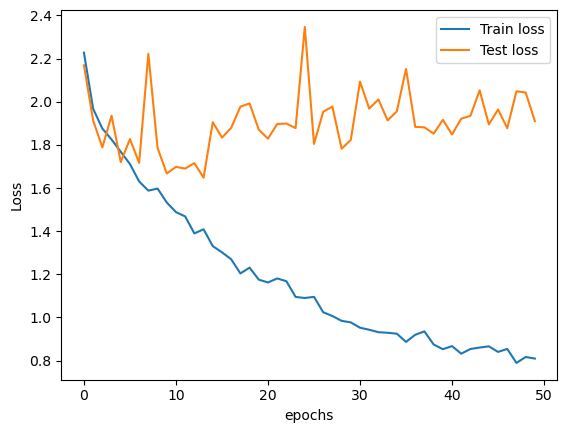

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

In [17]:
# Loading the real images for an evaluation of the model over these particular ones
dataset_root = './speed/speed/'
test_result=[]
q_est,r_est=[],[]
with open(os.path.join(dataset_root,'real.json'),'r') as f_eval:
  test_list=json.load(f_eval)

for img in test_list:
  img_path=os.path.join(dataset_root,'images','real',img['filename'])
  img_arr = Image.open(img_path).convert('RGB')
        
  # Apply transformations to the image
  transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  img_tensor = transform(img_arr).unsqueeze(0)  # Add batch dimension
        
  # Move the input tensor to the appropriate device
  img_tensor = img_tensor.to(device)
        
  # Perform inference
  outputs = model(img_tensor)
        
  # Convert the output tensor to a list
  output = outputs.squeeze().tolist()
        
  # Append the results
  test_result.append({'filename': img['filename'], 'q': output[:4], 'r': output[4:]})
  q_est.append(output[:4])
  r_est.append(output[4:])
  print(output)

[-0.0069288816303014755, 0.004953712224960327, 0.06492117047309875, 0.13845416903495789, -0.006885170936584473, -0.038876429200172424, 3.8405213356018066]
[-0.3368406593799591, 0.2513330280780792, -0.1949068307876587, 0.06056421995162964, -0.028589285910129547, -0.22044062614440918, 2.9507789611816406]
[-0.10134634375572205, 0.2587868869304657, -0.39886996150016785, -0.12710726261138916, 0.15727753937244415, -0.10677812993526459, 5.013700485229492]
[0.2843273878097534, 0.035701148211956024, -0.1303700953722, 0.14578185975551605, 0.24686147272586823, 0.07789931446313858, 6.740756988525391]
[-0.047076597809791565, 0.1348910629749298, -0.2355278879404068, -0.3185238242149353, 0.15258999168872833, -0.12355837225914001, 4.753043174743652]


In [18]:
real_json=[]
q_gt,r_gt=[],[]
with open(os.path.join(dataset_root,'real.json'),'r') as f:
  real_json=json.load(f)
for i in range(len(real_json)):
  q_gt.append(real_json[i]['q_vbs2tango'])
  r_gt.append(real_json[i]['r_Vo2To_vbs_true'])
     

In [19]:
import math
score_orientation=0
bra_ket=[]
for i in range(len(real_json)):
  bra_ket.append(q_est[i][0]*q_gt[i][0]+q_est[i][1]*q_gt[i][1]+q_est[i][2]*q_gt[i][2]+q_est[i][3]*q_gt[i][3])
  
  
for i in range(len(real_json)):
  if bra_ket[i]<1:
    score_orientation+=2*math.acos(bra_ket[i])
score_orientation


14.025565455984486

In [20]:
from numpy import linalg
score_position=0
for i in range(len(real_json)):
   score_position+=(abs(linalg.norm([r_gt[i]],2)-linalg.norm([r_est[i]],2))/linalg.norm([r_gt[i]],2))

#linalg.norm([r_gt[0]])
score_position

1.1849767527317405

In [21]:
score=(score_orientation+score_position)/len(real_json)
score

3.0421084417432454

In [58]:
torch.save(model.state_dict(), 'satellite_pose_estimation_model.pt')